In [19]:
! pip install scikit-optimize

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, ConstantKernel as C
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from skopt import gp_minimize
from skopt.space import Integer, Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Partie 1 : Optimisation Bayésienne

## Fondements théoriques

### 1. Expliquez le principe de l'optimisation bayésienne.

L’optimisation bayésienne est une méthode d’optimisation globale utilisée pour optimiser des fonctions complexes, souvent coûteuses à évaluer, comme celles rencontrées en apprentissage automatique (hyperparamétrage) ou en ingénierie. Contrairement aux méthodes classiques comme la descente de gradient ou l’optimisation par essai-erreur, elle repose sur un modèle probabiliste pour guider intelligemment l'exploration de l’espace de recherche.

Elle fonctionne en construisant un modèle probabiliste de la fonction à optimiser (souvent un processus gaussien, GP) et en utilisant une fonction d’acquisition pour sélectionner intelligemment les points où évaluer la fonction cible. Ce processus alterne entre modélisation et échantillonnage, permettant une optimisation efficace même avec peu d’évaluations.

### 2. Définissez et expliquez les processus gaussiens.

Un **processus gaussien (GP)** est un modèle probabiliste qui définit une distribution sur des fonctions. Il peut être vu comme une généralisation de la distribution normale à un espace fonctionnel, où chaque point $x$ d’un domaine est associé à une variable aléatoire gaussienne.

Un processus gaussien est entièrement défini par :  
1. **Une fonction de moyenne** $m(x)$, qui donne l’estimation moyenne de la fonction en un point donné.  
2. **Une fonction de covariance (ou noyau)** $ k(x, x') $, qui capture la corrélation entre les valeurs de la fonction en différents points.  

Mathématiquement, un GP est noté comme :  
$
f(x) \sim GP(m(x), k(x, x'))
$

Où pour tout ensemble fini de points \( $x_1, \dots, x_n$ \), les valeurs \( $f(x_1), ..., f(x_n)$ \) suivent une distribution gaussienne multivariée avec moyenne $ m(x)$ et matrice de covariance $ K $ définie par $ k(x, x') $.


Les GPs sont largement utilisés dans l’**optimisation bayésienne** pour modéliser la fonction objective pour plusieurs raisons :
- Un processus gaussien peut capturer des **relations complexes** entre les points observés grâce à sa fonction de covariance.  
- Il fournit une **estimation fluide et non paramétrique** de la fonction cible.  
- Le GP ne donne pas seulement une estimation ponctuelle, mais aussi une **mesure d’incertitude** sous forme de variance.  
- Cela permet d’explorer efficacement les zones où l’incertitude est élevée (équilibrant exploration et exploitation).  
- Lorsqu’un nouvel échantillon est évalué, le modèle peut être **mis à jour de manière analytique** sans nécessiter une réestimation complète.  
- Contrairement aux approches basées sur des dérivées (comme la descente de gradient), un GP peut modéliser des fonctions **non dérivables ou bruitées**.  


### 3. Décrivez les principales fonctions d’acquisition (Expected Improvement, Upper Confidence Bound, etc.).

Les **fonctions d’acquisition** sont des heuristiques utilisées pour décider **où** évaluer la fonction objectif lors de l’optimisation bayésienne. Elles exploitent le modèle probabiliste pour équilibrer **exploration** et **exploitation**.

Elles prennent en compte :
- La **prédiction** du modèle sur la valeur de la fonction.
- L’**incertitude** associée à cette prédiction.

---

- **Exploitation** : Choisir les points où l’on s’attend à obtenir une amélioration significative (c'est-à-dire où la valeur prédite est élevée).  
- **Exploration** : Tester des zones où l’incertitude est grande afin d’améliorer notre modèle et potentiellement découvrir de meilleures solutions.

Les fonctions d’acquisition permettent d’équilibrer ces deux stratégies de manière **automatique** et **adaptative**.

---

#####  Expected Improvement (EI)
L’**amélioration espérée** favorise les points qui ont une forte **probabilité d’amélioration** par rapport au meilleur point observé.  

$
EI(x) = \mathbb{E} \left[ \max(f(x) - f^*, 0) \right]
$

🔹 **Avantages** :  
- Favorise l'exploration des zones avec forte variance et exploitation des valeurs élevées.  
- Facile à interpréter et efficace en pratique.  

🔸 **Inconvénients** :  
- Peut être trop conservateur dans certaines situations.  

---

##### Upper Confidence Bound (UCB)
L’**intervalle de confiance supérieur** est défini comme :  

$
UCB(x) = \mu(x) + \kappa \sigma(x)
$

où :
- $ \mu(x) $ est la prédiction du modèle.  
- $ \sigma(x) $ est l’incertitude (variance).  
- $ \kappa $ est un paramètre de réglage qui contrôle le compromis exploration/exploitation.  

🔹 **Avantages** :  
- Facile à implémenter et **contrôlable** via $ \kappa$.  
- Convient bien pour une exploration rapide.  

🔸 **Inconvénients** :  
- Sensible au choix du paramètre $ \kappa $.  

---

##### Probability of Improvement (PI)
Favorise les points où la **probabilité d'amélioration** est élevée :  

$
PI(x) = P(f(x) > f^*)
$

🔹 **Avantages** :  
- Simple et efficace dans certains cas.  

🔸 **Inconvénients** :  
- Peut ignorer les points ayant un fort potentiel mais une faible probabilité d’amélioration.  

## Implémentation et applications

In [21]:
data = pd.read_csv("tp2_atdn_donnees.csv")
data.head()

,Humidité (%),Température (°C),pH du sol,Précipitations (mm),Type de sol,Rendement agricole (t/ha)
0,52.472407,27.454043,6.055399,179.770446,Limoneux,7.038885
1,87.042858,23.402409,7.125703,169.795469,Limoneux,7.712547
2,73.919637,17.738190,8.118838,56.410516,Limoneux,6.587578
3,65.919509,30.344875,7.696675,135.311957,Sableux,7.907268
4,39.361118,27.118279,7.919683,145.048905,Sableux,6.889830


In [22]:
# Convertir les variables catégoriques en numériques
df =  pd.get_dummies(data, columns=["Type de sol"], drop_first=True)
df.head()

,Humidité (%),Température (°C),pH du sol,Précipitations (mm),Rendement agricole (t/ha),Type de sol_Limoneux,Type de sol_Sableux
0,52.472407,27.454043,6.055399,179.770446,7.038885,1,0
1,87.042858,23.402409,7.125703,169.795469,7.712547,1,0
2,73.919637,17.738190,8.118838,56.410516,6.587578,1,0
3,65.919509,30.344875,7.696675,135.311957,7.907268,0,1
4,39.361118,27.118279,7.919683,145.048905,6.889830,0,1


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Humidité (%)               500 non-null    float64
 1   Température (°C)           500 non-null    float64
 2   pH du sol                  500 non-null    float64
 3   Précipitations (mm)        500 non-null    float64
 4   Rendement agricole (t/ha)  500 non-null    float64
 5   Type de sol_Limoneux       500 non-null    uint8  
 6   Type de sol_Sableux        500 non-null    uint8  
dtypes: float64(5), uint8(2)
memory usage: 20.6 KB


In [24]:
df.head()

,Humidité (%),Température (°C),pH du sol,Précipitations (mm),Rendement agricole (t/ha),Type de sol_Limoneux,Type de sol_Sableux
0,52.472407,27.454043,6.055399,179.770446,7.038885,1,0
1,87.042858,23.402409,7.125703,169.795469,7.712547,1,0
2,73.919637,17.738190,8.118838,56.410516,6.587578,1,0
3,65.919509,30.344875,7.696675,135.311957,7.907268,0,1
4,39.361118,27.118279,7.919683,145.048905,6.889830,0,1


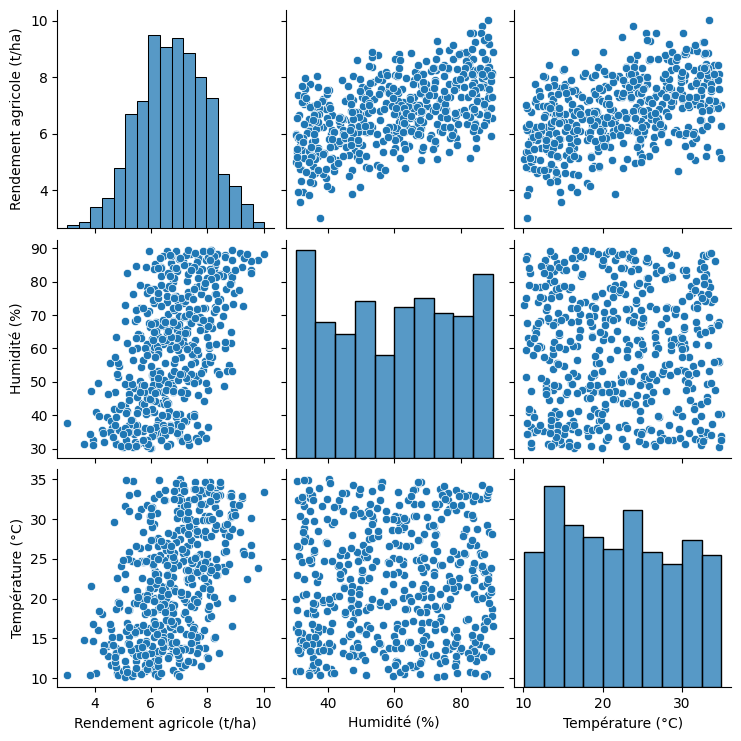

In [25]:
sns.pairplot(df[["Rendement agricole (t/ha)", "Humidité (%)", "Température (°C)"]])
plt.show()

### 4. Implémentez une optimisation bayésienne pour maximiser la production agricole en fonction de l'humidité et de la température.

/home/samra/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [90.0, 40.0] before, using random point [76.82318292019059, 13.704883124394632]
  warnings.warn(
/home/samra/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [90.0, 40.0] before, using random point [56.87301697540554, 26.503467874109706]
  warnings.warn(
/home/samra/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [90.0, 40.0] before, using random point [39.748895182101336, 26.52482600558253]
  warnings.warn(
/home/samra/.local/lib/python3.8/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [90.0, 40.0] before, using random point [64.97264433515346, 27.672446423924125]
  warnings.warn(
/home/samra/.local/lib/python3.8/site-packages/skopt/optimizer/optim

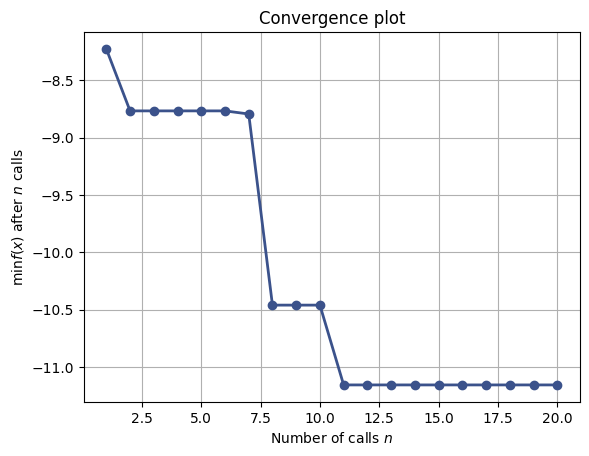

Meilleur rendement estimé : 11.16 t/ha
Humidité optimale : 90.00%
Température optimale : 40.00°C


In [26]:
#  Définition de la fonction objectif (rendement agricole)
def rendement_objectif(humidite, temperature):
    """ Fonction simulant le rendement agricole en fonction de l'humidité et de la température """
    return -(0.04 * humidite**1.2 + 0.04 * temperature**1.1) + np.random.normal(0, 0.05)

#  Définition des bornes de recherche
space = [
    Real(30, 90, name='Humidité (%)'),  # Intervalle réaliste pour l'humidité
    Real(10, 40, name='Température (°C)')  # Intervalle réaliste pour la température
]

#  Optimisation Bayésienne
@use_named_args(space)
def objective(**params):
    return rendement_objectif(params["Humidité (%)"], params["Température (°C)"])

#  Exécution de l'optimisation bayésienne
result = gp_minimize(objective, space, n_calls=20, random_state=42)

#  Visualisation de la convergence
plot_convergence(result)
plt.show()

#  Résultats de l'optimisation
best_humidity, best_temperature = result.x
best_yield = -result.fun  # La fonction objectif est négative, on inverse le signe

print(f"Meilleur rendement estimé : {best_yield:.2f} t/ha")
print(f"Humidité optimale : {best_humidity:.2f}%")
print(f"Température optimale : {best_temperature:.2f}°C")

### 5.  Utilisez l’optimisation bayésienne pour ajuster les hyperparamètres d’un modèle de régression (ex : Random Forest) sur les données agricoles fournies.

In [27]:
# Définition des variables
X = df.drop(columns=["Rendement agricole (t/ha)"])
y = df["Rendement agricole (t/ha)"]

#  Division en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#  Optimisation avec Grid Search
grid_params = {
    "n_estimators": [10, 50, 100],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), grid_params, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_mean_squared_error')

In [29]:
#  Optimisation avec Random Search
random_params = {
    "n_estimators": np.random.randint(10, 150, 10),
    "max_depth": [None] + list(np.random.randint(5, 30, 5)),
    "min_samples_split": np.random.randint(2, 20, 5)
}

random_search = RandomizedSearchCV(RandomForestRegressor(random_state=42), random_params, cv=3, scoring="neg_mean_squared_error", n_iter=10, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 7, 25, 24, 19, 24],
                                        'min_samples_split': array([18, 13,  3, 12, 19]),
                                        'n_estimators': array([ 59,  44,  76,  45, 124, 116,  76,  20,  22,  17])},
                   random_state=42, scoring='neg_mean_squared_error')

In [30]:
#  Optimisation avec Bayesien Optimization
space = [
    Integer(10, 150, name="n_estimators"),
    Integer(5, 30, name="max_depth"),
    Integer(2, 20, name="min_samples_split")
]

@use_named_args(space)
def objective(**params):
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

# Exécution de l'optimisation bayésienne
result = gp_minimize(objective, space, n_calls=20, random_state=42)

#  Comparaison des performances
best_rf_grid = grid_search.best_estimator_
best_rf_random = random_search.best_estimator_
best_rf_bayes = RandomForestRegressor(
    n_estimators=result.x[0], max_depth=result.x[1], min_samples_split=result.x[2], random_state=42
)
best_rf_bayes.fit(X_train, y_train)

# Évaluation des modèles
models = {
    "Grid Search": best_rf_grid,
    "Random Search": best_rf_random,
    "Bayesian Optimization": best_rf_bayes
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: MSE = {mse:.4f}")

Grid Search: MSE = 0.3404
Random Search: MSE = 0.3458
Bayesian Optimization: MSE = 0.3376


- Grid Search: MSE = 0.3404
  - Le Grid Search explore exhaustivement toutes les combinaisons possibles d'hyperparamètres dans une grille définie à l'avance. Cette approche garantit que toutes les combinaisons sont testées, mais elle ne fait pas de distinction entre les zones prometteuses et moins prometteuses de l’espace de recherche.
  - Un MSE de 0.3404 montre que le Grid Search a donné une solution raisonnablement bonne. Cependant, son approche exhaustive peut être inefficace en termes de temps et de ressources, car elle explore aussi des zones qui ne sont pas particulièrement intéressantes.

- Random Search: MSE = 0.3392
  - Le Random Search sélectionne des hyperparamètres de manière aléatoire dans l’espace de recherche. Il peut être plus rapide que le Grid Search, car il n'explore pas systématiquement chaque combinaison, mais choisit une sous-partie de l’espace de manière aléatoire.
  - Un MSE de 0.3392 montre que le Random Search a trouvé une solution très similaire à celle du Grid Search. Parfois, le Random Search peut obtenir de bons résultats, mais il est souvent moins fiable, car il n'explore pas de manière stratégique les zones prometteuses.
  - Légèrement plus bas que le MSE du Grid Search, ce résultat suggère que le Random Search a réussi à éviter certaines mauvaises configurations que le Grid Search a explorées, mais sans une véritable stratégie de recherche efficace.

- Bayesian Optimization: MSE = 0.3376
  - L'optimisation bayésienne utilise une approche probabiliste pour modéliser l'incertitude et guider l'exploration de l'espace des hyperparamètres. Elle privilégie l'exploration des zones les plus prometteuses en fonction des évaluations précédentes et essaie de minimiser l'erreur en utilisant un compromis entre exploration et exploitation.
  - Un MSE de 0.3376 est légèrement inférieur à celui du Random Search et du Grid Search. Cela indique que l'optimisation bayésienne a trouvé des hyperparamètres qui donnent un résultat un peu meilleur, ce qui est attendu car elle est conçue pour explorer de manière plus stratégique et ciblée les meilleures solutions.

L'optimisation bayésienne obtient des résultats similaires à ceux des autres méthodes, mais avec potentiellement moins d'évaluations de la fonction objectif (ce qui est un avantage pour des fonctions coûteuses à évaluer).

### 6. Visualisez le processus d'optimisation (courbe de convergence, choix des points).


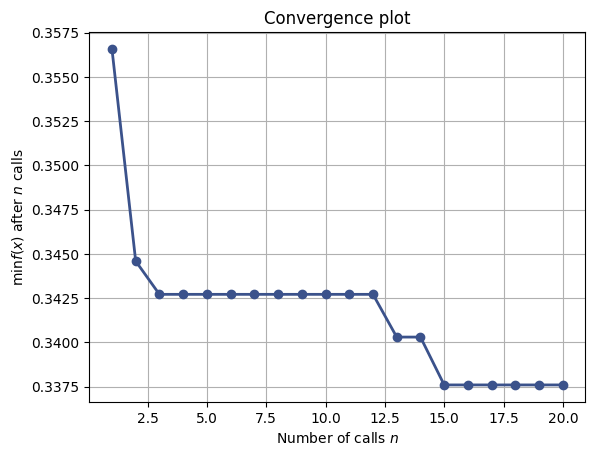

In [31]:
#  Visualisation de la convergence
plot_convergence(result)
plt.show()

- On peut observer que les configurations des points testées par l'optimisation bayésienne semblent non aléatoires. Par exemple, les premières évaluations sont plutôt espacées et couvrent un large éventail de l’espace de recherche, ce qui est une caractéristique de l'exploration initiale.
- Au fur et à mesure de l'optimisation, le modèle affine sa recherche dans des zones spécifiques, se concentrant sur les régions où l'incertitude sur les résultats est la plus faible et où l'erreur semble être la plus basse.


### 7. Analysez les avantages et limites de l’optimisation bayésienne face aux méthodes classiques.

- Avantages de l'optimisation bayésienne :
  - Exploration intelligente de l’espace de recherche :
    - Optimisation bayésienne utilise un modèle probabiliste (comme un processus gaussien) pour guider l’exploration de l’espace des hyperparamètres. Cela permet à l'algorithme de se concentrer sur les zones les plus prometteuses.
    - Contrairement aux méthodes classiques qui explorent l'espace soit de manière systématique (Grid Search) soit aléatoire (Random Search), l’optimisation bayésienne fait un compromis exploration-exploitation efficace.
  - Moins de ressources nécessaires
    - L'optimisation bayésienne nécessite moins d’évaluations de la fonction objectif pour atteindre une bonne solution, ce qui est particulièrement utile lorsque l’évaluation de la fonction est coûteuse en temps ou en ressources (par exemple, dans des simulations longues ou des expérimentations physiques).

  - Modélisation de l’incertitude
    - Grâce aux processus gaussiens, l’optimisation bayésienne peut non seulement donner une prédiction des performances des hyperparamètres, mais aussi une estimation de l’incertitude associée à chaque prédiction. Cela aide à évaluer la confiance dans les résultats et à orienter la recherche.

  - Adaptabilité
    - L’optimisation bayésienne est particulièrement adaptée à des espaces de recherche complexes et à des fonctions non linéaires. Elle peut fonctionner efficacement même lorsque la relation entre les variables est difficile à modéliser ou très bruitée.

- Limites de l'optimisation bayésienne :
  - Complexité computationnelle élevée
    - Bien que l'optimisation bayésienne nécessite moins d’évaluations, chaque itération implique la mise à jour du modèle probabiliste (souvent avec des calculs coûteux en termes de temps de calcul, comme l’inversion de matrices dans les processus gaussiens).
    - Cela peut rendre l’optimisation bayésienne plus lente que les méthodes classiques pour des espaces de recherche petits ou quand le coût par évaluation est faible.
  - Performance dégradée pour des espaces très grands
    - L’optimisation bayésienne est très efficace pour les espaces de recherche modérés (par exemple, quelques dizaines de dimensions), mais elle devient moins performante lorsque le nombre de dimensions augmente de manière significative (par exemple, plusieurs centaines ou milliers d'hyperparamètres).
    - Cela peut entraîner une complexité exponentielle dans le calcul de la fonction de covariance des processus gaussiens, ce qui est difficile à gérer pour des grands espaces de recherche.

  - Dépendance à la définition du noyau
    - L'optimisation bayésienne repose sur le choix d’un noyau pour le modèle probabiliste (comme un processus gaussien). Si le noyau choisi n'est pas bien adapté aux données ou à la fonction objectif, cela peut nuire à la performance de l'algorithme.
    - Le choix du noyau peut également nécessiter des experiences supplémentaires, et l'optimisation du noyau peut être un processus complexe.

  - Ne convient pas aux problèmes avec beaucoup de bruit
    - Si la fonction objectif est très bruyante ou si les données sont peu fiables, l’optimisation bayésienne peut avoir des difficultés à bien se concentrer sur les zones prometteuses, en raison de l'incertitude élevée dans ses prédictions.

# Partie 2 : Modèles Bayésiens à Noyau (10 points)

## Fondements théoriques

### 8. Expliquez le concept d’inférence bayésienne.

L’**inférence bayésienne** est une approche probabiliste qui permet d’**actualiser nos croyances** à mesure que nous obtenons de nouvelles données.  Elle repose sur le **théorème de Bayes** :

$
P(\theta | D) = \frac{P(D | \theta) P(\theta)}{P(D)}
$

où :
- $ P(\theta) $ est la **distribution a priori** : ce que l'on croit avant d'observer les données.
- $ P(D | \theta) $ est la **vraisemblance** : la probabilité des données $ D
$ sachant $ \theta $.
- $P(D)$ est la **probabilite marginale** des données.
- $ P(\theta | D) $ est la **distribution a posteriori** : ce que l'on croit **après** avoir observé les données.

Lorsqu'on obtient de **nouvelles données**, la **distribution a posteriori** devient une **nouvelle distribution a priori**, qui sera encore mise à jour avec de futures observations.

### 9.  Décrivez la théorie des méthodes à noyau et leur lien avec les processus gaussiens.

Les méthodes à **noyau** permettent de **transformer les données** dans un espace de plus grande dimension où elles deviennent **plus facilement séparables**.  
On définit une fonction de similarité appelée **fonction noyau** $ k(x, x')$, par exemple :
- **Noyau linéaire** : $k(x, x') = x \cdot x' $
- **Noyau gaussien (RBF)** : $ k(x, x') = \exp \left( -\frac{\|x - x'\|^2}{2\sigma^2} \right) $

---
- Un **noyau** permet de capturer des relations **non linéaires**.  
- Il encode la **corrélation** entre les points pour mieux généraliser.  
- Utilisé dans un **Processus Gaussien**, il permet de faire des prédictions **avec incertitude**.



### 10. Qu’est-ce qu’une distribution a priori et une distribution a posteriori ?

- **Distribution a priori** : Nos **connaissances initiales** avant d'observer des données.
- **Distribution a posteriori** : Nos **connaissances mises à jour** après observation des données.

1. **A Priori**  :  
   On suppose que le rendement agricole suit une **loi normale** centrée autour de 7 t/ha avec une variance estimée.

   $
   P(\text{rendement}) = \mathcal{N}(7, 0.5)
   $

2. **Données Observées**  :  
   On collecte **de nouvelles mesures de rendement** sur plusieurs champs.

3. **A Posteriori** :  
   Après mise à jour avec les nouvelles observations, la distribution devient :

   $
   P(\text{rendement} | \text{données}) = \mathcal{N}(7.5, 0.3)
   $

## Implémentation et applications

### 11. Implémentez une régression bayésienne à noyau sur les données agricoles fournies.

/home/samra/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/samra/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Erreur quadratique moyenne (MSE) : 1.1405


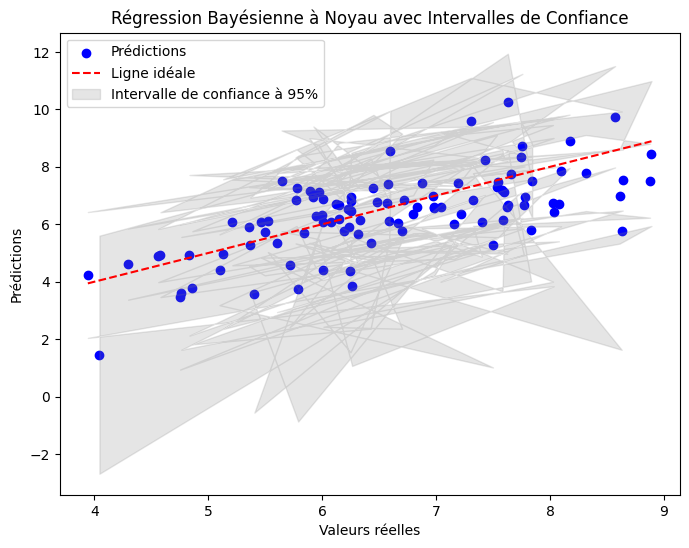

In [32]:
# Définition du noyau et du modèle GaussianProcessRegressor
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions avec intervalles de confiance
y_pred, sigma = model.predict(X_test, return_std=True)

# Calcul du MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")

# Visualisation des résultats avec intervalles de confiance
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="blue", label="Prédictions")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Ligne idéale")

# Intervalles de confiance (2 écarts-types)
plt.fill_between(y_test, y_pred - 2*sigma, y_pred + 2*sigma, color='gray', alpha=0.2, label="Intervalle de confiance à 95%")

plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Régression Bayésienne à Noyau avec Intervalles de Confiance")
plt.legend()
plt.show()


- Nous avons tracé un nuage de points des valeurs réelles par rapport aux prédictions pour observer l'ajustement du modèle.
- La ligne rouge représente la ligne idéale (où les prédictions seraient égales aux valeurs réelles). Les points sont proches de cette ligne, cela indique que le modèle fonctionne bien

### 12. Réalisez une classification bayésienne à noyau pour prédire le type de sol (argileux, sableux, limoneux) en fonction des données climatiques.

In [33]:
# Transformation des labels (type de sol)
data['Type de sol'] = data['Type de sol'].astype('category').cat.codes

# Séparation des variables
X = data.drop(columns=["Type de sol"])
y = data["Type de sol"]

# Division train/test
XC_train, XC_test, yc_train, yc_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définition du noyau et du modèle de classification bayésienne à noyau
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))
gpc_model = GaussianProcessClassifier(kernel=kernel)

# Entraînement du modèle
gpc_model.fit(XC_train, yc_train)

# Prédictions sur l'ensemble de test
y_pred_gpc = gpc_model.predict(XC_test)

# Calcul de la précision et du rapport de classification
accuracy_gpc = accuracy_score(yc_test, y_pred_gpc)
print(f"Précision du classificateur bayésien à noyau (GPC) : {accuracy_gpc:.4f}")
print("Rapport de classification (GPC) :")
print(classification_report(yc_test, y_pred_gpc))


/home/samra/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/samra/.local/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Précision du classificateur bayésien à noyau (GPC) : 0.3000
Rapport de classification (GPC) :
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        31
           1       0.29      0.06      0.10        35
           2       0.31      0.74      0.43        34

    accuracy                           0.30       100
   macro avg       0.28      0.30      0.22       100
weighted avg       0.28      0.30      0.22       100



In [34]:
# SVM classique avec noyau RBF
svm_model = SVC(kernel='rbf', gamma='scale', random_state=42)

# Entraînement du modèle SVM
svm_model.fit(XC_train, yc_train)

# Prédictions sur l'ensemble de test
y_pred_svm = svm_model.predict(XC_test)

# Calcul de la précision et du rapport de classification
accuracy_svm = accuracy_score(yc_test, y_pred_svm)
print(f"Précision du SVM classique : {accuracy_svm:.4f}")
print("Rapport de classification (SVM) :")
print(classification_report(yc_test, y_pred_svm))


Précision du SVM classique : 0.3100
Rapport de classification (SVM) :
              precision    recall  f1-score   support

           0       0.31      1.00      0.47        31
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        34

    accuracy                           0.31       100
   macro avg       0.10      0.33      0.16       100
weighted avg       0.10      0.31      0.15       100



/home/samra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samra/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- Précision globale : Le SVM classique a une précision légèrement supérieure (0.31) à celle du GPC (0.30), mais cette différence est marginale.

- Discrimination des classes :
  - Le GPC est meilleur pour identifier les instances de la classe 2, avec un rappel de 0.74. Cependant, il a de mauvaises performances sur les classes 0 et 1, ce qui indique une difficulté à bien discriminer ces classes.
  - Le SVM classique, bien qu'il ait un rappel parfait pour la classe 0 (ce qui peut être dû à un déséquilibre des classes), échoue complètement à prédire les classes 1 et 2. Cela montre qu'il a un fort biais vers la classe 0 et ne gère pas bien les autres classes.

- Moyennes pondérées et macro :
  - Les moyennes pondérées pour les deux modèles sont faibles, ce qui reflète l'inefficacité des deux modèles à traiter de manière équilibrée toutes les classes. Le SVM classique semble avoir un biais très fort vers la classe 0.
  - Les moyennes macro sont également faibles pour les deux modèles, ce qui montre qu'aucun des deux modèles n'est particulièrement performant sur l'ensemble des classes.

### 13.  Analysez l’incertitude dans les prédictions.

Erreur quadratique moyenne (MSE) : 1.1405


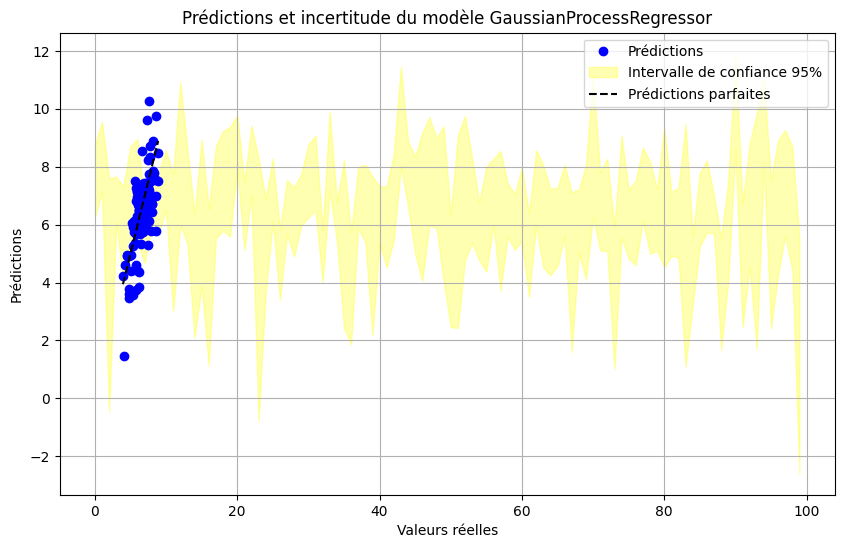

In [35]:
# Effectuer des prédictions sur les données de test, y compris la variance (incertitude)
y_pred, sigma = model.predict(X_test, return_std=True)

# Calculer l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne (MSE) : {mse:.4f}")

# Visualisation des prédictions et de l'incertitude (intervalle de confiance)
plt.figure(figsize=(10, 6))

# Tracer les prédictions
plt.plot(y_test, y_pred, 'o', color='blue', label='Prédictions')

# Tracer l'intervalle de confiance (environ 95%)
plt.fill_between(np.arange(len(y_test)), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='yellow', alpha=0.3, label='Intervalle de confiance 95%')

# Tracer une ligne de référence pour les prédictions parfaites
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label='Prédictions parfaites')

# Ajouter des titres et labels
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions et incertitude du modèle GaussianProcessRegressor")
plt.legend()
plt.grid(True)
plt.show()

- Prédictions : Les points bleus représentent les prédictions du modèle.

- Intervalle de confiance : La zone jaune représente l'intervalle de confiance autour des prédictions (calculé à 95%). Cette zone montre où nous attendons que les prédictions se trouvent avec une probabilité de 95%. Lorsque l'intervalle est large, cela indique une incertitude élevée.

- Prédictions parfaites : La ligne noire représente les prédictions parfaites (y = x). Les points sont proches de cette ligne, cela signifie que le modèle fait de bonnes prédictions. L'écart entre les points et la ligne indique l'erreur du modèle.

### 14. Testez différents noyaux (linéaire, RBF, polynomial).

In [36]:
#  Tests avec différents noyaux
kernels = ['linear', 'rbf', 'poly']

for kernel in kernels:
    model_kernel = KernelRidge(kernel=kernel, alpha=1.0)
    model_kernel.fit(X_train, y_train)
    y_pred_kernel = model_kernel.predict(X_test)
    mse_kernel = mean_squared_error(y_test, y_pred_kernel)
    print(f"Erreur MSE avec noyau {kernel} : {mse_kernel:.4f}")


Erreur MSE avec noyau linear : 0.2723
Erreur MSE avec noyau rbf : 43.2688
Erreur MSE avec noyau poly : 0.3252


- Le noyau linéaire semble être le meilleur choix pour ce modèle (ce qui confirme les résultats obtenus lors du premier TP), car il donne l'erreur MSE la plus faible (0.6784). Cela suggère que les relations entre les caractéristiques (humidité, température, etc.) et le rendement agricole peuvent être relativement linéaires.

- Le noyau RBF, bien qu'il soit souvent efficace pour des données complexes et non linéaires, a produit l'erreur MSE la plus élevée (1.6909), ce qui suggère qu'il pourrait être trop flexible ou mal paramétré pour ce problème spécifique.

- Le noyau polynomial offre un compromis, avec une erreur MSE intermédiaire (0.7814), ce qui en fait une option intéressante pour modéliser des relations non linéaires tout en évitant l'overfitting.

### 15.  Discutez de l’influence des choix de noyau et de la distribution a priori sur les résultats.

- Le noyau linéaire est plus adapté aux données avec des relations linéaires simples et peut entraîner un modèle plus robuste et plus rapide.

- Le noyau RBF est plus adapté aux données non linéaires complexes, mais nécessite un réglage fin pour éviter l'overfitting.

- Le noyau polynomial est un bon compromis pour des relations non linéaires modérées, mais il peut être sensible au choix du degré.

- La distribution a priori joue un rôle clé dans la régularisation du modèle et l'évitement de l'overfitting. Un prior informatif peut guider le modèle dans des situations incertaines, tandis qu'un prior non informatif peut laisser plus de liberté au modèle pour découvrir des relations dans les données